In [ ]:
!pip install webdriver-manager
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

# Final Project

### Team: Anastasia, Nurassyl 
### 67-364 Practical Data Sceince 
### Instructor: Professor Houda Boumour 


### Goal:
We decided to work on the Housing Market Analysis in Kazakhstan. Amid Russian-Ukrainian military conflict and partial mobilization in Russia, Kazakhstan became an option for many Russian migrants. Because of that, it's reported that **more than one million Russian migrants entered the territory of Kazakhstan**. Therefore, housing market of Kazakhstan expected to have certain challenges for the citizens. Housing prices increased reportedly by at least 15% in one year, and it is reported to grow harder even more in upcoming months. In this project, we will consider a scenario of immigrants who want to buy an apartment in Ust-Kamenogorsk - small town in the East Kazakhstan Region, one of the regions sharing border with Russia. Immigrants can enter their preferences in terms of number of square meters (area), the number of bedrooms, and other details and our model is supposed to predict the price of the apartment for them.

## Part 1: Data collection
To collect data, we decided to use Kazakhstani housing marketplace called **Krisha.kz**. It is known to be most convenient and popular platform in Kazakhstan, and it contains almost 300 thousand apartments listed as for sale. The subset we are going to use - from Ust'-Kamenogorsk contains 4000+ apartments listed for sale. Every listed apartment contains information about the area, number of bedrooms, number of toilets, internet connectivity and other important details for filtering the ads. 

### Tools
In order to collect the data, we decided to parse everything from the website. The tools that we will use are: **NumPy, pandas, BeautifulSoup, Selenium on top of ChromeDriver**
Let's import them.

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import sys
import time
sys.path.insert(0,'/usr/local/bin/chromedriver')
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

## NOTE: If you have data parsed already, proceed to step 2 directly

Code below fetch the number of pages with advertisements that we will be paginating on and other one parses the total number of ads available for parsing. (Note: Not all of the pages are valid for parsing)

In [ ]:
def request_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    parsed_list_of_ads = soup.find('section', attrs={'class': 'a-search-container main-cols-container'})
    total_ad_number = get_total_number_ads(parsed_list_of_ads)
    number_of_pages = int(total_ad_number/20) + 1

    print("The total number of apartments found by search is " + str(total_ad_number))
    print("The total number of pages found by search is " + str(number_of_pages))
    return number_of_pages

In [ ]:
# The function below gets the total number of ads
def get_total_number_ads(parsed_list):
    text = parsed_list.find(class_="a-search-subtitle search-results-nb").get_text()
    res = [int(i) for i in text.split() if i.isdigit()] 
    total_number = res[0]*1000+res[1]
    return total_number

The function below is needed to parse important keyboards that we will be parsing from the requests and link descriptions. 

In [ ]:
# The function tokenize is needed to get the list of words from web scraping 
def tokenize(content):
    splitter = [" ", "\n", ",", ")", "\"", "–", "-", "/", "\xa0"]
    result_list = []
    current_word = ""
    for x in content:
        if x in splitter:
            if current_word != "":
                result_list.append(current_word)
            current_word = ""
        else:
            current_word += x
    return result_list

Now we are getting all the text needed from a certain page:

In [ ]:
# getting the whole text from the specific page
def get_soup_spec_page(url, page_number):
    URL = url+'?das[checked]=1&das[who]=1&page=' + str(page_number)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    full_list = soup.find('section', attrs={'class': 'a-list a-search-list a-list-with-favs'})
    return full_list

In [1]:
import re
from IPython import display

The parse_data function is needed to parse the data from the page with the apartment details. Initially, we initiate all the values to some defaults, and the parse function fills them depending on what is listed on the apartment page. The apartment page looks as shown below:

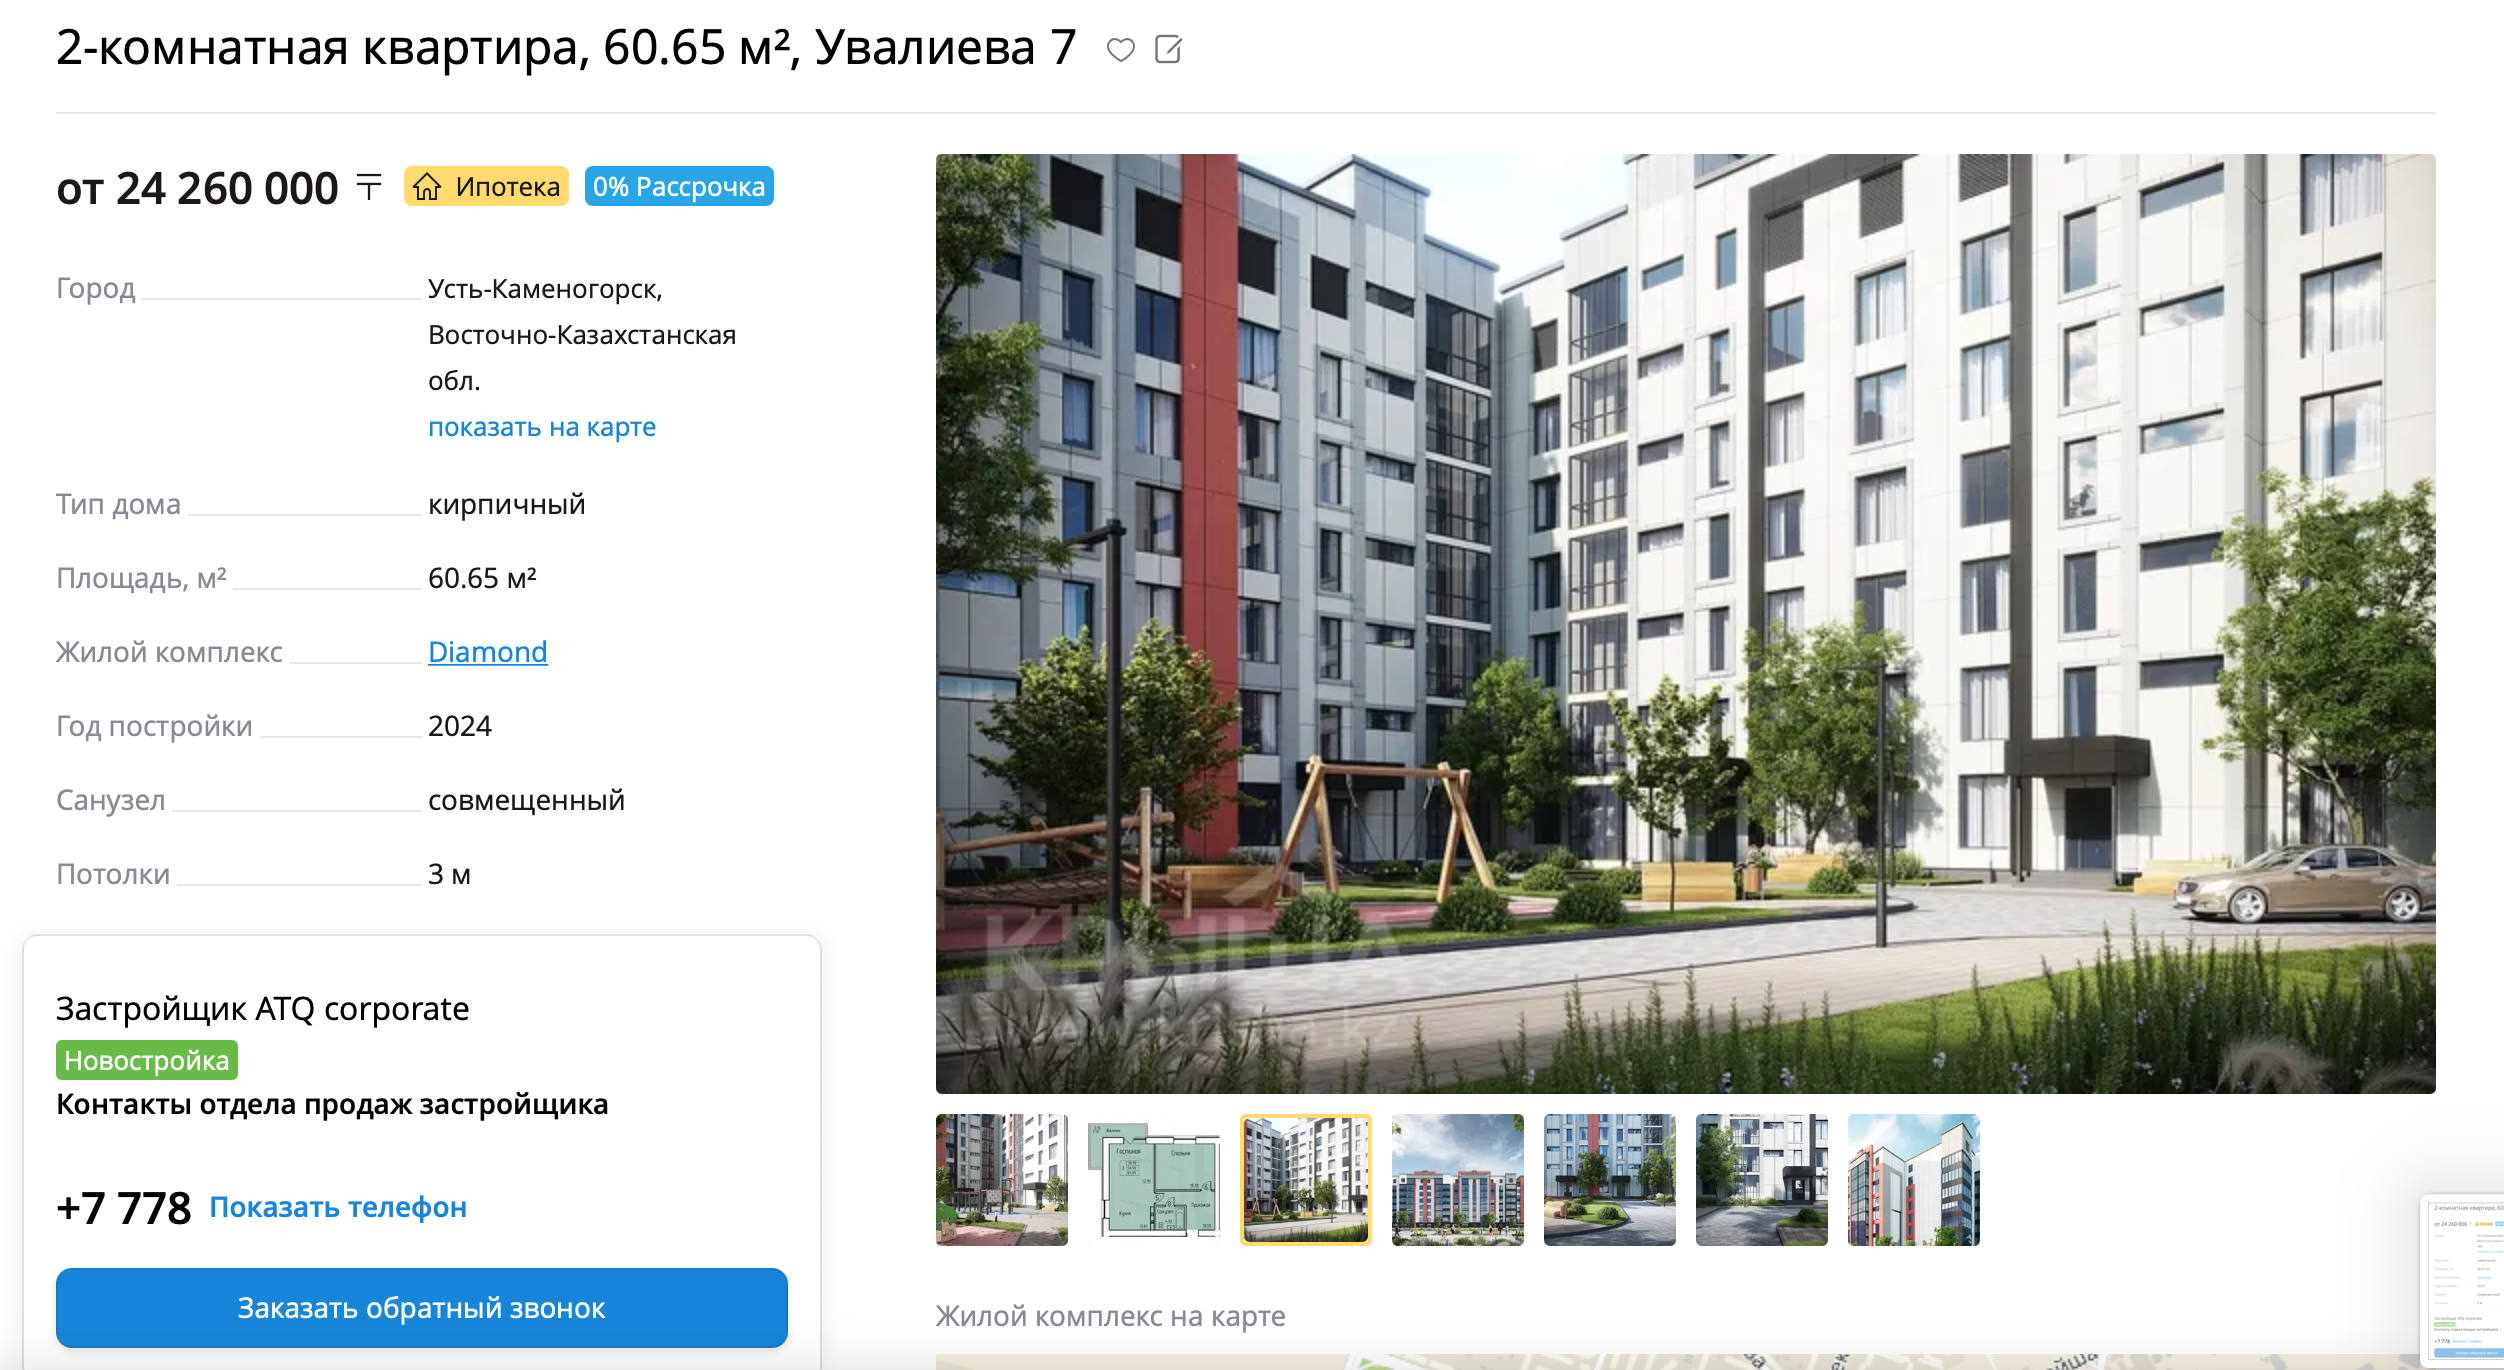

In [8]:
display.Image("/Users/anastasia/Desktop/pds_final_project_anastasia_nurassyl/images/krusha.png")

In [ ]:
def parse_data(krisha_link):
	headers = {'User-Agent': 'Mozilla/5.0'}
	response = requests.get(krisha_link, headers=headers)
	type_house = -1
	map_complex = -1
	building = -1
	built_time = -1
	floor = -1
	space = -1
	renovation = -1
	toilet = -1
	balcony = -1
	door = -1
	phone = -1
	ceiling = -1
	security = -1
	priv_dorm = -1
	internet = -1
	furniture = -1
	flooring = -1
	balcony_glass = -1
	parking = -1
	longitude = 0.0
	latitude = 0.0

	if (response.status_code == 200):
		soup = BeautifulSoup(response.text, 'lxml')

		pattern = re.compile(r'"lat":')
		script_text = soup.find('script', text=pattern)
		if (script_text != None):
			all_script_text = script_text.string
			lat = re.search('"lat":(.+?),"lon":', all_script_text)
			if lat:
			    latitude = lat.group(1)

			lon = re.search('"lon":(.+?),"zoom"', all_script_text)
			if lon:
			    longitude = lon.group(1)

		main_info = soup.find_all('div', class_='offer__info-item')
		for info in main_info:
			current_info = info.find('div', class_='offer__info-title').text
			current_value = info.find('div', class_='offer__advert-short-info').text
			if current_info == 'Тип дома':
				type_house = current_value
			elif current_info == 'Санузел':
				toilet = current_value
			elif current_info == 'Состояние':
				renovation = current_value
			elif (current_info == "Этаж"):
				floor = current_value
			elif (current_info == "Площадь"):
				living_space = current_value
				d_space = living_space.split(',')
				space = d_space[0]
			elif (current_info == "Балкон"):
				balcony = current_value
			elif (current_info == "Дверь"):
				door = current_value
			elif (current_info == "Телефон"):
				phone = current_value
			elif (current_info == "Потолки"):
				ceiling = current_value
			elif (current_info == "Безопасноть"):
				security = current_value
			elif (current_info == "Бывшее общежитие"):
				priv_dorm = current_value
			elif (current_info == "Интернет"):
				internet = current_value
			elif (current_info == "Мебель"):
				furniture = current_value
			elif (current_info == "Пол"):
				flooring = current_value
			elif (current_info == "Балкон остеклен"):
				balcony_glass = current_value
			elif (current_info == "Парковка"):
				parking = current_value


		dt = soup.find_all('dt')
		dd = soup.find_all('dd')
		for i in range(len(dt)):
			if (dt[i].text == "Жилой комплекс"):
				map_complex = dd[i].text
			elif (dt[i].text == "Дом"):
				home = dd[i].text
				divider = home.split(',')
				if "г.п." in divider[0]:
					built_time = divider[0]
					building = -1
				else:
					building = divider[0]
					built_time = divider[1]
			elif (dt[i].text == "Этаж"):
				floor = dd[i].text
			elif (dt[i].text == "Площадь"):
				living_space = dd[i].text
				d_space = living_space.split(',')
				space = d_space[0]
			elif (dt[i].text == "Состояние"):
				renovation = dd[i].text
			elif (dt[i].text == "Санузел"):
				toilet = dd[i].text
			elif (dt[i].text == "Балкон"):
				balcony = dd[i].text
			elif (dt[i].text == "Дверь"):
				door = dd[i].text
			elif (dt[i].text == "Телефон"):
				phone = dd[i].text
			elif (dt[i].text == "Потолки"):
				ceiling = dd[i].text
			elif (dt[i].text == "Безопасноть"):
				security = dd[i].text
			elif (dt[i].text == "Бывшее общежитие"):
				priv_dorm = dd[i].text
			elif (dt[i].text == "Интернет"):
				internet = dd[i].text
			elif (dt[i].text == "Мебель"):
				furniture = dd[i].text
			elif (dt[i].text == "Пол"):
				flooring = dd[i].text
			elif (dt[i].text == "Балкон остеклен"):
				balcony_glass = dd[i].text
			elif (dt[i].text == "Парковка"):
				parking = dd[i].text
	else:
		print("Failed to load page: --> ", krisha_link)
		return 0
	ans = type_house, renovation, toilet, balcony, balcony_glass, door, phone, ceiling, security, priv_dorm, internet, furniture, flooring, parking, latitude,longitude
	return ans

In [ ]:
def get_df_list(full_list):
    df_apartments = pd.DataFrame(columns=['number_of_rooms', 'area', 'storey_number', 
                                          'total_storey_number', 'price', 'district', 
                                          'complex_name', 'year', 'renovation', 'type_house', 'toilet', 'balcony',
                                          'balcony_glass', 'door', 'phone', 'ceiling', 'security', 'priv_dorm', 'intermnet',
                                          'furniture', 'flooring', 'parking', 'latitude', 'longitude'])
    adv_elems = full_list.find_all(True, {'class':['a-card__descr']})
    for elem in adv_elems:
        data_id = elem.find('a', class_='a-card__title').get_text()
        number_of_bedrooms_with_area_draft = elem.find('a', class_='a-card__title').get_text()
        number_of_bedrooms_with_area = tokenize(number_of_bedrooms_with_area_draft)
        number_of_rooms = int(number_of_bedrooms_with_area[0])
        area = float(number_of_bedrooms_with_area[3])
        ahref = elem.find('a', class_='a-card__title')['href']
        type_house, renovation, toilet, balcony, balcony_glass, door, phone, ceiling, security, priv_dorm, internet, furniture, flooring, parking, latitude,longitude = parse_data("https://krisha.kz" + ahref)
        if len(number_of_bedrooms_with_area) > 5:
            storey_number = number_of_bedrooms_with_area[5]
            if len(number_of_bedrooms_with_area) < 7:
                total_storey_number = np.nan
            else:
                total_storey_number = number_of_bedrooms_with_area[6]
        else:
            storey_number = np.nan
            total_storey_number = np.nan
        
        price_draft = tokenize(elem.find('div', class_='a-card__price').get_text())
        if price_draft[0].isnumeric() and price_draft[1].isnumeric() and price_draft[2].isnumeric():
            price = int(price_draft[0]+price_draft[1]+price_draft[2])
        elif price_draft[1].isnumeric() and price_draft[2].isnumeric() and price_draft[3].isnumeric():
            price = int(price_draft[1]+price_draft[2]+price_draft[3])
        else:
            price = np.nan
            
        district_draft = elem.find('div', class_='a-card__subtitle').get_text()
        district_draft = tokenize(district_draft)
        district = np.nan

        if len(district_draft)>1 and district_draft[1] == 'р' and district_draft[2] == 'н':
            district = district_draft[0]
        complex_name_draft = elem.find('div', class_ = 'a-card__text-preview').get_text()
        complex_name_draft = tokenize(complex_name_draft)
        year = np.nan
        for i in range(11):
            if len(complex_name_draft[i]) == 4 and complex_name_draft[i].isdigit():
                year = int(complex_name_draft[i])
                break

        apartment_type_list = ['кирпичный', 'монолитный', 'панельный']
        complex_name = np.nan
        if complex_name_draft[0] == 'жил.':
            complex_name = complex_name_draft[2]
            if complex_name_draft[3].isnumeric() == False and complex_name_draft[3] not in apartment_type_list:
                complex_name += ' '
                complex_name += complex_name_draft[3]
        condition = np.nan
        df_apartments.loc[len(df_apartments.index)] = [number_of_rooms, area, storey_number, total_storey_number, price, district, complex_name, year, renovation, type_house, toilet, balcony, balcony_glass, door, phone, ceiling, security, priv_dorm, internet, furniture, flooring, parking, latitude,longitude]
    return df_apartments

We now specify the place that we will be parsing using the following links. As we can see, we only parse apartments from Ust'-Kamenogorsk

In [ ]:
urls = ['https://krisha.kz/prodazha/']
submenu = ['kvartiry/ust-kamenogorsk/']

This function basically parses all the data from all pages into pandas dataframe. Also, we try to convert everything to csv at every page (20 apartments) for the sake of safe parsing data and to not lose any apartment halfway parsing.

In [ ]:
for i in range(len(urls)):
  for j in range(len(submenu)):
    number_of_pages = request_page(urls[i]+submenu[j])
    print("This sub-category has " + str(number_of_pages) + "pages")
    df = pd.DataFrame(columns=['number_of_rooms', 'area', 'storey_number', 
                                          'total_storey_number', 'price', 'district', 
                                          'complex_name', 'year', 'renovation', 'type_house', 'toilet', 'balcony',
                                          'balcony_glass', 'door', 'phone', 'ceiling', 'security', 'priv_dorm', 'intermnet',
                                          'furniture', 'flooring', 'parking', 'latitude', 'longitude'])
    for k in range(number_of_pages):
        df = df.append(get_df_list(get_soup_spec_page(urls[i]+submenu[j], k+1)), ignore_index = True)
        df.to_csv("output.csv")
df

Now, this dataframe needs some wrangling in order to make everything look much better. First, we will get rid of -1 values and replace them all with NaN values.

In [ ]:
df.head()

## Part 2: Data Wrangling
We will be converting some of the data fields to Categorical since there are distinct categories for each of the apartments

### NOTE: To run with the data already parsed, use the code chunk below. It saves time.

In [86]:
df = pd.read_csv("output.csv")
df['ceiling'] = df['ceiling'].str.extract(r'([-+]?\d*\.?\d+)').astype('float')
df['area'] = df['area'].apply(float)
df = df.dropna(subset=['price'], how='all')
df = df.replace([-1, '-1', 'NaN', 'nan'], np.NaN)
df.head()

,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,district,complex_name,year,renovation,...,phone,ceiling,security,priv_dorm,intermnet,furniture,flooring,parking,latitude,longitude
0,0,2,60.00,7.0,9.0,25000000.0,NaN,NaN,2018,хорошее,...,NaN,2.5,NaN,NaN,ADSL,NaN,NaN,паркинг,49.889894,82.594099
1,1,1,50.12,NaN,NaN,20048000.0,NaN,Diamond,2024,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.895234,82.616464
2,2,1,32.55,NaN,NaN,10904250.0,NaN,Grand Residence,2024,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.958610,82.620374
3,3,1,39.15,NaN,NaN,14094000.0,NaN,Crystal,2024,NaN,...,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN,49.902152,82.614102
4,4,1,36.40,NaN,NaN,12740000.0,NaN,Viva Park,2023,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.920948,82.619388


In [87]:
df.renovation = pd.Categorical(df.renovation)
df.type_house = pd.Categorical(df.type_house)
df.toilet = pd.Categorical(df.toilet)
df.balcony = pd.Categorical(df.balcony)
df.door = pd.Categorical(df.door)
df.phone = pd.Categorical(df.phone)
df.security = pd.Categorical(df.security)
df.priv_dorm = pd.Categorical(df.priv_dorm)
df.intermnet = pd.Categorical(df.intermnet)
df.furniture = pd.Categorical(df.furniture)
df.flooring = pd.Categorical(df.flooring)
df.parking = pd.Categorical(df.parking)
df.head()

,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,district,complex_name,year,renovation,...,phone,ceiling,security,priv_dorm,intermnet,furniture,flooring,parking,latitude,longitude
0,0,2,60.00,7.0,9.0,25000000.0,NaN,NaN,2018,хорошее,...,NaN,2.5,NaN,NaN,ADSL,NaN,NaN,паркинг,49.889894,82.594099
1,1,1,50.12,NaN,NaN,20048000.0,NaN,Diamond,2024,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.895234,82.616464
2,2,1,32.55,NaN,NaN,10904250.0,NaN,Grand Residence,2024,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.958610,82.620374
3,3,1,39.15,NaN,NaN,14094000.0,NaN,Crystal,2024,NaN,...,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN,49.902152,82.614102
4,4,1,36.40,NaN,NaN,12740000.0,NaN,Viva Park,2023,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,49.920948,82.619388


Let us see what are the columns with most unknown (NaN) values:

In [89]:
df.isnull().sum()

Unnamed: 0                0
number_of_rooms           0
area                      0
storey_number           106
total_storey_number     128
price                     0
district               4046
complex_name           3800
year                      0
renovation              802
type_house              126
toilet                  438
balcony                1254
balcony_glass          4046
door                    798
phone                  2154
ceiling                 557
security               4046
priv_dorm              4046
intermnet              1812
furniture              4046
flooring               1013
parking                2358
latitude                  0
longitude                 0
dtype: int64

What is the percentage of the apartments with NaN values after parsing?

In [90]:
df.isnull().sum()/len(df)

Unnamed: 0             0.000000
number_of_rooms        0.000000
area                   0.000000
storey_number          0.026199
total_storey_number    0.031636
price                  0.000000
district               1.000000
complex_name           0.939199
year                   0.000000
renovation             0.198220
type_house             0.031142
toilet                 0.108255
balcony                0.309936
balcony_glass          1.000000
door                   0.197232
phone                  0.532378
ceiling                0.137667
security               1.000000
priv_dorm              1.000000
intermnet              0.447850
furniture              1.000000
flooring               0.250371
parking                0.582798
latitude               0.000000
longitude              0.000000
dtype: float64

Observation: Only number of Rooms, Area, Price, Year of Construction, Latitude and Longitude are the fields with least unknown values.
Most of the categorical values are missing.
Also, the storey number and total storey number is missing in few of the datafields.
District, Balcony_glass, Security, Priv_dorm and Furniture are the fields with all values that are unknown.
Therefore, we can get rid most of them (Only columns <2K missing values are left).

In [91]:
apartments = df.drop(['district','complex_name','balcony', 'balcony_glass', 'phone', 'security', 'priv_dorm', 'furniture', 'parking'], axis=1)
apartments.head()

,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,year,renovation,type_house,toilet,door,ceiling,intermnet,flooring,latitude,longitude
0,0,2,60.00,7.0,9.0,25000000.0,2018,хорошее,монолитный,раздельный,металлическая,2.5,ADSL,NaN,49.889894,82.594099
1,1,1,50.12,NaN,NaN,20048000.0,2024,NaN,кирпичный,раздельный,NaN,3.0,NaN,NaN,49.895234,82.616464
2,2,1,32.55,NaN,NaN,10904250.0,2024,NaN,монолитный,совмещенный,NaN,3.0,NaN,NaN,49.958610,82.620374
3,3,1,39.15,NaN,NaN,14094000.0,2024,NaN,монолитный,совмещенный,NaN,2.8,NaN,NaN,49.902152,82.614102
4,4,1,36.40,NaN,NaN,12740000.0,2023,NaN,монолитный,совмещенный,NaN,3.0,NaN,NaN,49.920948,82.619388


Now we are going to get rid of NaN values since they negatively affect our calculations.

In [92]:
apartments = apartments.dropna()
apartments.head()

,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,year,renovation,type_house,toilet,door,ceiling,intermnet,flooring,latitude,longitude
41,41,3,56.0,5.0,5.0,22900000.0,1966,хорошее,панельный,совмещенный,металлическая,2.5,проводной,линолеум,49.966047,82.601186
47,47,2,50.0,5.0,9.0,22000000.0,1994,хорошее,кирпичный,раздельный,металлическая,2.5,оптика,линолеум,49.980497,82.578468
48,48,3,80.0,7.0,9.0,41000000.0,2007,хорошее,кирпичный,совмещенный,металлическая,2.0,ADSL,ламинат,49.896202,82.620455
59,59,2,60.0,3.0,9.0,35000000.0,1985,хорошее,кирпичный,раздельный,бронированная,2.0,оптика,дерево,49.947258,82.594269
61,61,3,75.0,7.0,9.0,32000000.0,1989,хорошее,кирпичный,раздельный,бронированная,2.5,проводной,ламинат,49.967137,82.590362


In [93]:
apartments.shape

(1433, 16)

As we can see, we are left with limited number of rows that can contribute towards our model. Now, let's explore them and see the data distribution for each of the columns.

## Data Visuzalization and Analysis
Now, we can do some analysis to check the values in different columns.
First, we can check what are the most expensive and largest apartments in the city.

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns

In [95]:
apartments.info

<bound method DataFrame.info of       Unnamed: 0  number_of_rooms  area  storey_number  total_storey_number  \
41            41                3  56.0            5.0                  5.0   
47            47                2  50.0            5.0                  9.0   
48            48                3  80.0            7.0                  9.0   
59            59                2  60.0            3.0                  9.0   
61            61                3  75.0            7.0                  9.0   
...          ...              ...   ...            ...                  ...   
4035        4035                1  44.0            4.0                  5.0   
4037        4037                2  44.8            1.0                  5.0   
4043        4043                2  55.7            4.0                  5.0   
4044        4044                4  86.0            4.0                  5.0   
4046        4046                2  58.0            4.0                  5.0   

           price  y

In [96]:
apartments.describe()

,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,year,ceiling,latitude,longitude
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1433.000000,1433.000000,1433.000000,1433.000000
mean,2048.980461,2.358688,58.533217,3.915562,6.347523,2.413967e+07,1988.184927,2.662966,49.939661,82.616067
std,1141.005209,0.879481,18.523510,2.315659,2.273378,1.035248e+07,18.717467,1.603565,0.038561,0.036377
min,41.000000,1.000000,18.000000,1.000000,2.000000,4.500000e+06,1951.000000,2.000000,49.735920,82.483893
25%,1056.000000,2.000000,45.700000,2.000000,5.000000,1.700000e+07,1973.000000,2.500000,49.900386,82.597279
50%,2014.000000,2.000000,58.000000,4.000000,5.000000,2.250000e+07,1987.000000,2.500000,49.949025,82.612748
75%,3042.000000,3.000000,70.000000,5.000000,9.000000,2.950000e+07,2006.000000,2.700000,49.963938,82.628531
max,4046.000000,8.000000,185.000000,16.000000,16.000000,9.500000e+07,2022.000000,27.000000,50.044920,82.773628


From the table above, we can see that the prices for apartments start from 4.5mln Kazakhstani Tenge to almost 100mln Kazakhstani tenge. The price range values differ sagnificantly. 

Additionally, we can notice that the number of rooms range between 1 and 8 with a mean of 2.35. We camj make a conclusion that 2 bedroom apartments are the average ones and probably te highesrt demand, so the price of two-bedroom apartments might be overpriced. 


Also, the area of the apartment ranges from 18 sq.m to 185sq.m. Generally, we can see that the data is distributed. Similarly , we can understand so many things by just looking at the describe function.
Now, we are going to see some visualization and also going to see how and what can we infer from visualization.

## apartments['number_of_rooms'].value_counts().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

As we can see from the chart above 3 bedroom apartments are most commonly sold followed by 2 bedroom. Therefore, the migrants can use this data to look more at 3 bedroom apartments since there is higher offer for them.

Now, let's take a look at locations of the apartments and find out if there is something interesting like common locations and how they are distributed in the city.

/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

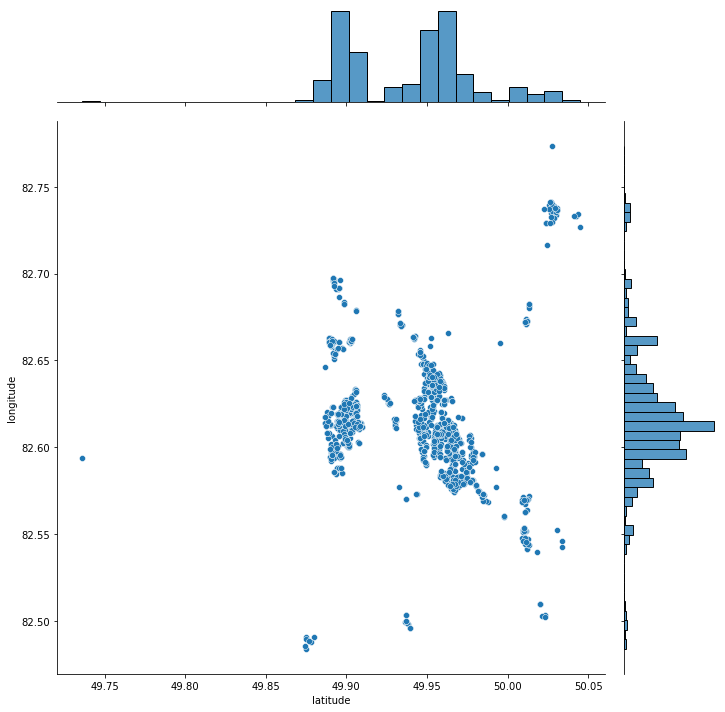

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [98]:
plt.figure(figsize=(10,10))
sns.jointplot(x=apartments.latitude, y=apartments.longitude, size=10)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Longitude", fontsize=12)
plt.show()
sns.despine

From the figure above we can clearly notice the fact that apartments are clearly splitted into two different groups in the middle, with much more apartments on the right side, and comparitively less on the left. Interestingly, the city of Ust'-Kameneogorsk has a river in the middle of the city and the left shore of the city is considered as "New City" and right shore is considered as "Old City". Clearly, "New City" has much less apartments and houses at this moment, therefore the size difference explain that too.

Now let's check the dependencies between different common aspects and the price of the apartments.

Text(0.5, 0, 'Square Meters')

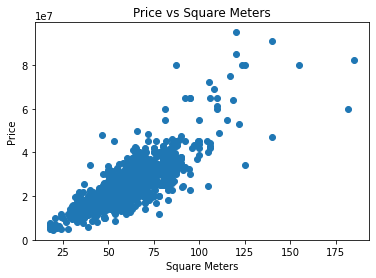

In [99]:
plt.scatter(apartments.area, apartments.price)
plt.title("Price vs Square Meters")
plt.ylabel("Price")
plt.xlabel("Square Meters")

Text(0.5, 0, 'Longitude')

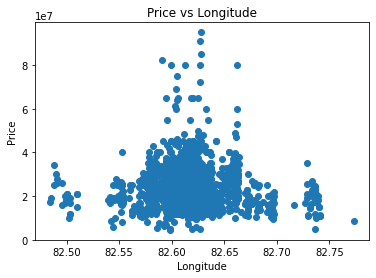

In [100]:
plt.scatter(apartments.longitude, apartments.price)
plt.title("Price vs Longitude")
plt.ylabel("Price")
plt.xlabel("Longitude")

Text(0.5, 0, 'Latitude')

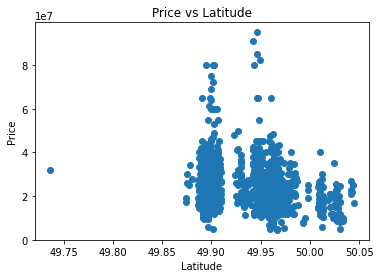

In [101]:
plt.scatter(apartments.latitude,apartments.price)
plt.title("Price vs Latitude")
plt.ylabel("Price")
plt.xlabel("Latitude")

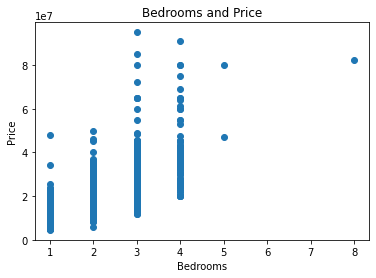

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [102]:
plt.scatter(apartments.number_of_rooms, apartments.price)
plt.title("Bedrooms and Price")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.show()
sns.despine

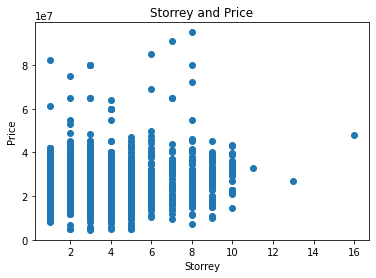

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [103]:
plt.scatter(apartments.storey_number, apartments.price)
plt.title("Storrey and Price")
plt.xlabel("Storrey")
plt.ylabel("Price")
plt.show()
sns.despine

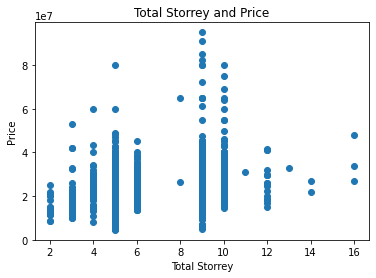

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [104]:
plt.scatter(apartments.total_storey_number, apartments.price)
plt.title("Total Storrey and Price")
plt.xlabel("Total Storrey")
plt.ylabel("Price")
plt.show()
sns.despine

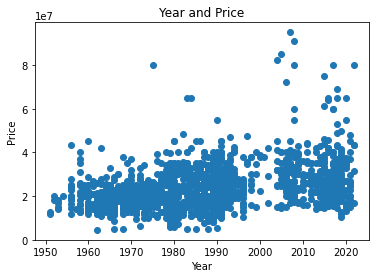

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [105]:
plt.scatter(apartments.year, apartments.price)
plt.title("Year and Price")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()
sns.despine

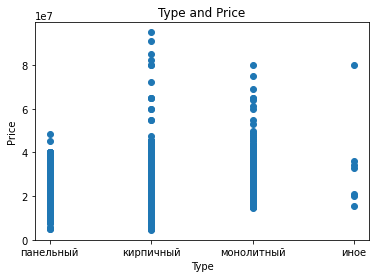

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [106]:
plt.scatter(apartments.type_house, apartments.price)
plt.title("Type and Price")
plt.xlabel("Type")
plt.ylabel("Price")
plt.show()
sns.despine

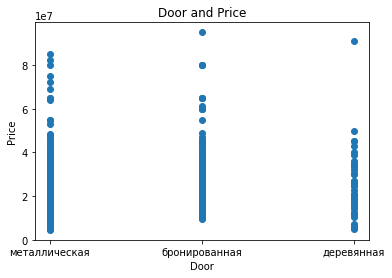

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [107]:
plt.scatter(apartments.door, apartments.price)
plt.title("Door and Price")
plt.xlabel("Door")
plt.ylabel("Price")
plt.show()
sns.despine

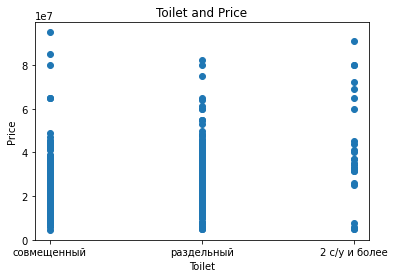

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [108]:
plt.scatter(apartments.toilet, apartments.price)
plt.title("Toilet and Price")
plt.xlabel("Toilet")
plt.ylabel("Price")
plt.show()
sns.despine

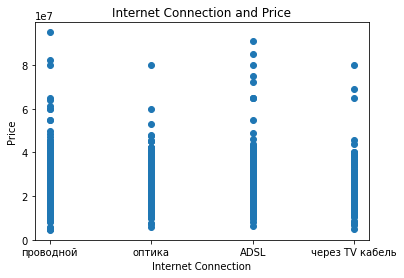

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [109]:
plt.scatter(apartments.intermnet, apartments.price)
plt.title("Internet Connection and Price")
plt.xlabel("Internet Connection")
plt.ylabel("Price")
plt.show()
sns.despine

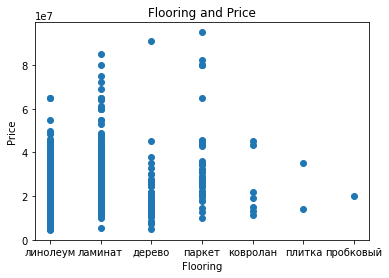

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [110]:
plt.scatter(apartments.flooring, apartments.price)
plt.title("Flooring and Price")
plt.xlabel("Flooring")
plt.ylabel("Price")
plt.show()
sns.despine

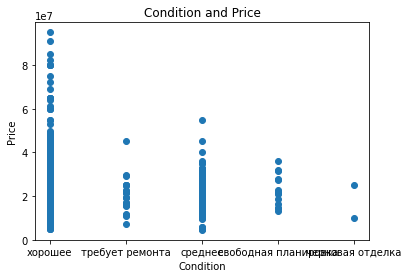

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [111]:
plt.scatter(apartments.renovation, apartments.price)
plt.title("Condition and Price")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.show()
sns.despine

In [117]:
apartments_df = apartments
categorical_cols = ['renovation', 'type_house', 'toilet', 'door', 'intermnet', 'flooring'] 

from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
apartments_df[categorical_cols] = apartments_df[categorical_cols].apply(lambda col: le.fit_transform(col))    
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, categories='auto') 

#One-hot-encode the categorical columns.
#Unfortunately outputs an array instead of dataframe.
array_hot_encoded = ohe.fit_transform(apartments_df[categorical_cols])

#Convert it to df
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=apartments.index)

#Extract only the columns that didnt need to be encoded
data_other_cols = apartments_df.drop(columns=categorical_cols)

#Concatenate the two dataframes : 
apartments_final = pd.concat([data_hot_encoded, data_other_cols], axis=1)
apartments_final.head()

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 0,number_of_rooms,area,storey_number,total_storey_number,price,year,ceiling,latitude,longitude
41,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,41,3,56.0,5.0,5.0,22900000.0,1966,2.5,49.966047,82.601186
47,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,47,2,50.0,5.0,9.0,22000000.0,1994,2.5,49.980497,82.578468
48,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,48,3,80.0,7.0,9.0,41000000.0,2007,2.0,49.896202,82.620455
59,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,59,2,60.0,3.0,9.0,35000000.0,1985,2.0,49.947258,82.594269
61,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,61,3,75.0,7.0,9.0,32000000.0,1989,2.5,49.967137,82.590362


## Part 3: Linear Regression
For this dataset, we ended up choosing Linear Regression for prediction model. Model in statistics is something which helps us to predict the future based upon relationship of variables.
Regression tries to learn the line
$$ y = mx + b $$
that will help us to predict on new inputs after learning. Since we are trying to predict the price we are going to use price as y-value and all the remaining attributes will take a role of X - predictors.
In this case, we are going to use **sklearn ML library** for the Linear Regression.

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [119]:
reg = LinearRegression()

We will need to convert the categorical values into numeric values. We will use OneHotEncoder for that purpose. The point of Linear Regression is to learn separate Linear Regressor for each of the attributes and then use the linear combination of them to create a final linear function.

In [128]:
y = apartments_final['price']
train_data = apartments_final.drop(['Unnamed: 0','price'], axis=1)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=2)

In [132]:
reg.fit(X_train, y_train)

/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [133]:
reg.score(X_test, y_test)

/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.7773587077051318

Basically, our Linear Regression got a decent accuracy. However, we can work on making it even better. We can try other models that can work better. Now, we can try on Gradient Boost Regression algorithm.

In [141]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 500, max_depth = 7, min_samples_split = 2, learning_rate = 0.2, loss = 'ls')
clf.fit(X_train, y_train)

/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(learning_rate=0.2, loss='ls', max_depth=7,
                          n_estimators=500)

In [142]:
clf.score(X_test, y_test)

/Users/nzekenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8501298588754366

### We got much better results! Now, we can use this model to make predictions for our migrants.This model can be used for predicting current prices for renting or buying real estate in Kazakhstan for Russians ad Ukranians who are fleeing the country during the military operations and war events. 

### This reserach can be extended to a bigger one with predictions of real estate market in different countries across the globe and wilol require feeding more data. 